In [1]:
!git clone https://github.com/benavoli/prefGP.git

Cloning into 'prefGP'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (390/390), done.
remote: Compressing objects: 100% (250/250), done.
remote: Total 390 (delta 165), reused 350 (delta 136), pack-reused 0 (from 0)
Receiving objects: 100% (390/390), 40.73 MiB | 9.22 MiB/s, done.
Resolving deltas: 100% (165/165), done.


In [2]:
!cd prefGP && sudo chmod -R u+w .

## In abstractModel.py, comment out line 3-6, 27-55, 77-105 since we are not optimizing hyperparameters to prevent bugs.

In [1]:
!pwd

/content


In [2]:
%cd prefGP

/content/prefGP


In [3]:
!pwd

/content/prefGP


In [4]:
!sudo apt-get update -y

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 128 kB in 6s (23.1 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [5]:
!sudo apt-get install python3.11

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.11 is already the newest version (3.11.12-1+jammy1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [6]:
!python --version

Python 3.11.12


In [7]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1

In [8]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.11 2

In [9]:
!python --version

Python 3.11.12


In [10]:
!sudo apt-get install python3.11-distutils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'python3-distutils' instead of 'python3.11-distutils'
python3-distutils is already the newest version (3.10.8-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [11]:
!wget https://bootstrap.pypa.io/get-pip.py

--2025-04-21 01:42:18--  https://bootstrap.pypa.io/get-pip.py
Resolving bootstrap.pypa.io (bootstrap.pypa.io)... 151.101.0.175, 151.101.64.175, 151.101.128.175, ...
Connecting to bootstrap.pypa.io (bootstrap.pypa.io)|151.101.0.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2300175 (2.2M) [text/x-python]
Saving to: ‘get-pip.py.1’

get-pip.py.1        100%[===================>]   2.19M  --.-KB/s    in 0.08s   

2025-04-21 01:42:18 (27.9 MB/s) - ‘get-pip.py.1’ saved [2300175/2300175]



In [12]:
!python get-pip.py

  Using cached pip-25.0.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-25.0.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 25.0.1
    Uninstalling pip-25.0.1:
      Successfully uninstalled pip-25.0.1


In [13]:
!python -m pip install ipython ipython_genutils ipykernel jupyter_console prompt_toolkit httplib2 astor

In [14]:
!ln -s /usr/local/lib/python3.10/dist-packages/google \
       /usr/local/lib/python3.11/dist-packages/google

ln: failed to create symbolic link '/usr/local/lib/python3.11/dist-packages/google/google': File exists


In [15]:
!python --version

Python 3.11.12


In [16]:
!pip --version

pip 25.0.1 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)


# Now the code part...

In [18]:
%load_ext autoreload
%autoreload 2
import sys,os
sys.path.append('../')
import numpy as np
from model.exactPreference import  exactPreference
from model.LuceJND import  LuceJND
# from model.erroneousPreference import  erroneousPreference
from model.gaussianNoisePreferenceFull import  gaussianNoisePreference
from kernel import RBF
from utility import  paramz
# for plotting
import matplotlib.pyplot as plt
import arviz as az

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
!pip install -r requirements.txt

In [19]:
from scipy.stats import multivariate_normal
means = [np.array([-2, 3]), np.array([0, -3]), np.array([2, 2])]
covariances = [np.array([[2, 1], [1, 2]]), np.array([[10, -3], [-3, 4]]), np.array([[2, 0], [0, 2]])]
weights = [5/1.6, 22/1.6, 10/1.6]
step_size = 0.5
x, y = np.mgrid[-5:5+step_size:step_size, -5:5+step_size:step_size]
pos = np.dstack((x, y))
# print(pos.shape)
gmm_pdf = np.zeros(x.shape)
for mean, cov, weight in zip(means, covariances, weights):
    rv = multivariate_normal(mean, cov)
    gmm_pdf += weight * rv.pdf(pos)

In [20]:
np.random.seed(42)
X = pos.reshape(-1, 2)
print(X[:10])
m = 50
Pairs = []
for ii in range(m):
    i=np.random.randint(X.shape[0])
    j=np.random.randint(X.shape[0])
    value1 = 0
    value2 = 0
    x = np.array([X[i], X[j]])
    for mean, cov, weight in zip(means, covariances, weights):
        rv = multivariate_normal(mean, cov)
        values = weight * rv.pdf(x)
        value1 += values[0]
        value2 += values[1]
    if value1 >= value2:
        Pairs.append([i, j])
    else:
        Pairs.append([j, i])
Pairs = np.array(Pairs)

[[-5.  -5. ]
 [-5.  -4.5]
 [-5.  -4. ]
 [-5.  -3.5]
 [-5.  -3. ]
 [-5.  -2.5]
 [-5.  -2. ]
 [-5.  -1.5]
 [-5.  -1. ]
 [-5.  -0.5]]


In [21]:
print(X.shape, Pairs.shape)
print(Pairs)

(441, 2) (50, 2)
[[102 435]
 [348 270]
 [ 71 106]
 [188  20]
 [121 102]
 [330 214]
 [372  87]
 [ 99 359]
 [151 130]
 [308 149]
 [257 343]
 [413 293]
 [191 385]
 [276 160]
 [313  21]
 [235 252]
 [ 48 344]
 [169  58]
 [187 270]
 [174 189]
 [ 50 363]
 [243  54]
 [130 319]
 [306 134]
 [328  20]
 [273 166]
 [ 88 387]
 [315  13]
 [264 241]
 [ 52 345]
 [339 385]
 [ 91 366]
 [263 427]
 [ 34 430]
 [205  80]
 [ 49 419]
 [359 387]
 [389   1]
 [ 53 105]
 [309 259]
 [190 401]
 [217  43]
 [161 201]
 [350 269]
 [303 270]
 [214 251]
 [295 189]
 [212 207]
 [236 337]
 [ 52 366]]


In [23]:
# Data dictionary
data = {}
data["Pairs"] = Pairs
data["X"] = X
Xpred = X

# define kernel and hyperparams
Kernel = RBF

#kernel parameter dictionary
params={'lengthscale': {'value':1.5*np.ones(data["X"].shape[1],float),
                        'range':np.vstack([[0.1, 20.0]]*data["X"].shape[1]),
                        'transform': paramz.logexp()},
             'variance': {'value':np.array([1.0]),
                        'range':np.vstack([[1.0, 1.0001]]),
                        'transform': paramz.logexp()}#variance not used in exactPreference
          }


#define preference model
model = exactPreference(data,Kernel,params)
#compute hyperparameters
#model.optimize_hyperparams(num_restarts=2) we do not optimise the hyperparameters
print(model.params)
#sample from posterior
model.sample(nsamples=4000, tune=500)
#predicted samples
predictions = model.predict(Xpred)

{'lengthscale': {'value': array([1.5, 1.5]), 'range': array([[ 0.1, 20. ],
       [ 0.1, 20. ]]), 'transform': <utility.paramz.logexp object at 0x7a64c4582290>}, 'variance': {'value': array([1.]), 'range': array([[1.    , 1.0001]]), 'transform': <utility.paramz.logexp object at 0x7a64842ae210>}}


100%|██████████| 4500/4500 [00:21<00:00, 211.02it/s]


In [24]:
predictions.shape

(441, 4000)

(10201, 4000)


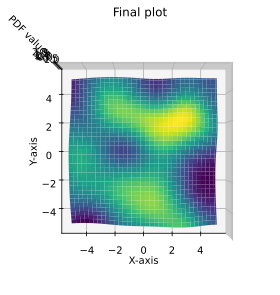

In [25]:
%config InlineBackend.figure_format = 'svg'
step_size = 0.1
x, y = np.mgrid[-5:5+step_size:step_size, -5:5+step_size:step_size]
pos = np.dstack((x, y))
Xpred = pos.reshape(-1, 2)
y_pred = model.predict(Xpred)
print(y_pred.shape)
y_pred_mean = np.mean(y_pred, axis=1).reshape(x.shape)
y_pred_std = np.std(y_pred, axis=1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, y_pred_mean, cmap='viridis')
ax.view_init(elev=90, azim=-90)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('PDF value')
ax.set_title('Final plot')
# plt.show()
plt.savefig("sim2_bl2_td.pdf")

In [26]:
def get_metrics(corr_list, predictions):
    y_pred = []
    y_pred = np.mean(predictions, axis=1)
    corr = np.corrcoef(gmm_pdf.flatten(), y_pred.flatten())[0, 1]
    print(">>> corr:", corr)
    corr_list.append(corr)

In [27]:
# Use a for loop to iterate through all X
import time
from tqdm import tqdm
corr_list = []
time_list = []
Xpred = X
print(Xpred.shape)
for i in tqdm(range(1, 51)):
  start = time.time()
  data = {}
  data["Pairs"] = Pairs[:i]
  data["X"] = X

  # define kernel and hyperparams
  Kernel = RBF

  #kernel parameter dictionary
  params={'lengthscale': {'value':1.5*np.ones(data["X"].shape[1],float),
                          'range':np.vstack([[0.1, 20.0]]*data["X"].shape[1]),
                          'transform': paramz.logexp()},
              'variance': {'value':np.array([1.0]),
                          'range':np.vstack([[1.0, 1.0001]]),
                          'transform': paramz.logexp()}#variance not used in exactPreference
            }


  #define preference model
  model = exactPreference(data,Kernel,params)
  #compute hyperparameters
  #model.optimize_hyperparams(num_restarts=2) we do not optimise the hyperparameters
  # print(model.params)
  #sample from posterior
  model.sample(nsamples=1000, tune=125)
  #predicted samples
  predictions = model.predict(Xpred)
  # print(Xpred.shape, Xpred[:6], predictions.shape)
  end = time.time()
  time_list.append(end - start)
  # corr_list.append(np.corrcoef(np.mean(predictions,axis=1),fun(Xpred[:,0]))[0, 1])
  get_metrics(corr_list, predictions)
  # print(f"Time taken for iteration {i}: {end - start} seconds")
  # print(">>> i:", np.corrcoef(np.mean(predictions,axis=1),fun(Xpred[:,0]))[0, 1])
print(corr_list)
print(time_list)

(441, 2)


  2%|▏         | 1/50 [00:00<00:32,  1.51it/s]

>>> corr: -0.016963142812817654


  4%|▍         | 2/50 [00:01<00:33,  1.43it/s]

>>> corr: -0.03951777670997823


  6%|▌         | 3/50 [00:02<00:36,  1.30it/s]

>>> corr: -0.09643681923862689


  8%|▊         | 4/50 [00:03<00:38,  1.18it/s]

>>> corr: -0.011897684291532153


 10%|█         | 5/50 [00:04<00:51,  1.14s/it]

>>> corr: 0.10804543031606936


 12%|█▏        | 6/50 [00:07<01:07,  1.54s/it]

>>> corr: 0.034975903552252836


 14%|█▍        | 7/50 [00:08<01:00,  1.41s/it]

>>> corr: 0.2700726547020014


 16%|█▌        | 8/50 [00:09<00:56,  1.34s/it]

>>> corr: -0.13391071809046992


 18%|█▊        | 9/50 [00:10<00:54,  1.34s/it]

>>> corr: 0.19767125159436308


 20%|██        | 10/50 [00:12<00:55,  1.38s/it]

>>> corr: 0.10413946107912471


 22%|██▏       | 11/50 [00:13<00:55,  1.43s/it]

>>> corr: 0.42856671280179554


 24%|██▍       | 12/50 [00:16<01:03,  1.68s/it]

>>> corr: 0.239046738311392


 26%|██▌       | 13/50 [00:19<01:25,  2.31s/it]

>>> corr: 0.3103478698876307


 28%|██▊       | 14/50 [00:23<01:36,  2.68s/it]

>>> corr: 0.48671708850061196


 30%|███       | 15/50 [00:25<01:24,  2.42s/it]

>>> corr: 0.630909126059737


 32%|███▏      | 16/50 [00:27<01:16,  2.24s/it]

>>> corr: 0.41969392143813333


 34%|███▍      | 17/50 [00:28<01:10,  2.14s/it]

>>> corr: 0.4079878976121052


 36%|███▌      | 18/50 [00:31<01:12,  2.26s/it]

>>> corr: 0.7480230676292321


 38%|███▊      | 19/50 [00:34<01:18,  2.54s/it]

>>> corr: 0.526238356189239


 40%|████      | 20/50 [00:36<01:11,  2.39s/it]

>>> corr: 0.741261525416237


 42%|████▏     | 21/50 [00:38<01:07,  2.34s/it]

>>> corr: 0.7281162986934497


 44%|████▍     | 22/50 [00:41<01:04,  2.31s/it]

>>> corr: 0.670200153451685


 46%|████▌     | 23/50 [00:43<01:02,  2.33s/it]

>>> corr: 0.6531566089734462


 48%|████▊     | 24/50 [00:47<01:16,  2.93s/it]

>>> corr: 0.6452726325508237


 50%|█████     | 25/50 [00:50<01:09,  2.79s/it]

>>> corr: 0.6774463580544844


 52%|█████▏    | 26/50 [00:53<01:05,  2.75s/it]

>>> corr: 0.801123483904913


 54%|█████▍    | 27/50 [00:55<01:02,  2.72s/it]

>>> corr: 0.8342900294453134


 56%|█████▌    | 28/50 [00:59<01:09,  3.17s/it]

>>> corr: 0.7445892913580395


 58%|█████▊    | 29/50 [01:02<01:05,  3.13s/it]

>>> corr: 0.7229369686345198


 60%|██████    | 30/50 [01:05<01:00,  3.03s/it]

>>> corr: 0.6223024327414278


 62%|██████▏   | 31/50 [01:08<00:56,  2.95s/it]

>>> corr: 0.8615371928940981


 64%|██████▍   | 32/50 [01:12<00:57,  3.20s/it]

>>> corr: 0.6266386563759577


 66%|██████▌   | 33/50 [01:16<00:57,  3.38s/it]

>>> corr: 0.7548769040482298


 68%|██████▊   | 34/50 [01:19<00:52,  3.28s/it]

>>> corr: 0.6811552781333053


 70%|███████   | 35/50 [01:22<00:49,  3.27s/it]

>>> corr: 0.7613822016075937


 72%|███████▏  | 36/50 [01:27<00:53,  3.79s/it]

>>> corr: 0.7922406076525839


 74%|███████▍  | 37/50 [01:30<00:47,  3.67s/it]

>>> corr: 0.7580077179988464


 76%|███████▌  | 38/50 [01:34<00:43,  3.60s/it]

>>> corr: 0.8184674960931013


 78%|███████▊  | 39/50 [01:38<00:41,  3.81s/it]

>>> corr: 0.8356427879636528


 80%|████████  | 40/50 [01:42<00:39,  3.99s/it]

>>> corr: 0.7546155146785402


 82%|████████▏ | 41/50 [01:46<00:34,  3.88s/it]

>>> corr: 0.746423180891464


 84%|████████▍ | 42/50 [01:50<00:30,  3.82s/it]

>>> corr: 0.8035390509624069


 86%|████████▌ | 43/50 [01:55<00:30,  4.37s/it]

>>> corr: 0.651571274675955


 88%|████████▊ | 44/50 [01:59<00:25,  4.25s/it]

>>> corr: 0.831899658103826


 90%|█████████ | 45/50 [02:03<00:20,  4.16s/it]

>>> corr: 0.6921382447597394


 92%|█████████▏| 46/50 [02:09<00:18,  4.74s/it]

>>> corr: 0.8137103158683555


 94%|█████████▍| 47/50 [02:13<00:13,  4.50s/it]

>>> corr: 0.8411202715824221


 96%|█████████▌| 48/50 [02:18<00:09,  4.54s/it]

>>> corr: 0.69967790472876


 98%|█████████▊| 49/50 [02:23<00:04,  4.77s/it]

>>> corr: 0.7773869312687215


100%|██████████| 50/50 [02:27<00:00,  2.96s/it]

>>> corr: 0.7245541438688461
[-0.016963142812817654, -0.03951777670997823, -0.09643681923862689, -0.011897684291532153, 0.10804543031606936, 0.034975903552252836, 0.2700726547020014, -0.13391071809046992, 0.19767125159436308, 0.10413946107912471, 0.42856671280179554, 0.239046738311392, 0.3103478698876307, 0.48671708850061196, 0.630909126059737, 0.41969392143813333, 0.4079878976121052, 0.7480230676292321, 0.526238356189239, 0.741261525416237, 0.7281162986934497, 0.670200153451685, 0.6531566089734462, 0.6452726325508237, 0.6774463580544844, 0.801123483904913, 0.8342900294453134, 0.7445892913580395, 0.7229369686345198, 0.6223024327414278, 0.8615371928940981, 0.6266386563759577, 0.7548769040482298, 0.6811552781333053, 0.7613822016075937, 0.7922406076525839, 0.7580077179988464, 0.8184674960931013, 0.8356427879636528, 0.7546155146785402, 0.746423180891464, 0.8035390509624069, 0.651571274675955, 0.831899658103826, 0.6921382447597394, 0.8137103158683555, 0.8411202715824221, 0.69967790472876, 0